## Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point, MultiPoint

from scipy.stats import chi2_contingency
from tabulate import tabulate

from sklearn.cluster import DBSCAN

In [2]:
!pip install --upgrade matplotlib

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
shooting_frame = pd.read_csv('./fatal-police-shootings-data.csv').dropna()
shooting_frame_w_na = pd.read_csv('./fatal-police-shootings-data.csv')
shooting_frame

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,7335,Brian Michael Price,2021-11-06,shot,piece of wood,45.0,M,W,Chesapeake,VA,False,attack,Other,False,-78.691,36.653,True
6854,7332,Chelsae L. Clevenger-Kirk,2021-11-07,shot,gun,29.0,F,W,Goodview,VA,True,other,Other,False,-79.699,37.174,True
6969,7444,Shawn Martin,2021-12-21,shot,knife,45.0,M,W,Savannah,GA,False,attack,Not fleeing,False,-81.140,32.043,True
6975,7443,Brian Douglas Laxton,2021-12-22,shot,gun,44.0,M,W,Battle Creek,MI,False,attack,Car,True,-85.175,42.309,True


In [5]:
shooting_frame.head(5).drop('is_geocoding_exact', axis=1).to_latex(index=False)

'\\begin{tabular}{rllllrllllllllrr}\n\\toprule\n id &               name &       date &  manner\\_of\\_death &      armed &  age & gender & race &          city & state &  signs\\_of\\_mental\\_illness & threat\\_level &        flee &  body\\_camera &  longitude &  latitude \\\\\n\\midrule\n  3 &         Tim Elliot & 2015-01-02 &             shot &        gun & 53.0 &      M &    A &       Shelton &    WA &                     True &       attack & Not fleeing &        False &   -123.122 &    47.247 \\\\\n  4 &   Lewis Lee Lembke & 2015-01-02 &             shot &        gun & 47.0 &      M &    W &         Aloha &    OR &                    False &       attack & Not fleeing &        False &   -122.892 &    45.487 \\\\\n  5 & John Paul Quintero & 2015-01-03 & shot and Tasered &    unarmed & 23.0 &      M &    H &       Wichita &    KS &                    False &        other & Not fleeing &        False &    -97.281 &    37.695 \\\\\n  8 &    Matthew Hoffman & 2015-01-04 &            

In [6]:
nunique_frame = pd.DataFrame(shooting_frame_w_na.nunique(), columns=['Count'])
nunique_frame.to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  Count \\\\\n\\midrule\nid                      &   7139 \\\\\nname                    &   6781 \\\\\ndate                    &   2435 \\\\\nmanner\\_of\\_death         &      2 \\\\\narmed                   &     98 \\\\\nage                     &     80 \\\\\ngender                  &      2 \\\\\nrace                    &      6 \\\\\ncity                    &   2988 \\\\\nstate                   &     51 \\\\\nsigns\\_of\\_mental\\_illness &      2 \\\\\nthreat\\_level            &      3 \\\\\nflee                    &      4 \\\\\nbody\\_camera             &      2 \\\\\nlongitude               &   5667 \\\\\nlatitude                &   5041 \\\\\nis\\_geocoding\\_exact      &      2 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [7]:
census_frame = pd.read_csv('./acs2017_county_data.csv')
census_frame.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,51107,Virginia,Loudoun County,374558,185575,188983,13.5,57.7,7.2,0.2,...,1.7,1.1,7.0,33.7,201528,78.7,16.8,4.4,0.1,3.8
1,51059,Virginia,Fairfax County,1142004,565593,576411,16.2,51.7,9.3,0.1,...,1.9,1.7,6.3,32.1,609859,73.6,20.8,5.5,0.1,4.5
2,24027,Maryland,Howard County,312495,152843,159652,6.5,54.1,18.1,0.2,...,1.0,1.1,5.7,30.9,167493,73.0,22.7,4.2,0.1,4.2
3,51610,Virginia,Falls Church city,13843,6801,7042,10.6,72.0,4.5,0.0,...,2.4,2.8,6.7,28.9,7672,64.6,28.5,6.9,0.0,4.2
4,51013,Virginia,Arlington County,229534,114403,115131,15.5,62.3,8.5,0.3,...,5.0,2.8,6.6,28.6,143798,70.8,24.9,4.2,0.2,3.2


In [8]:
cities_frame = pd.read_csv('./worldcities.csv')
cities_frame = cities_frame[(cities_frame.country == 'United States') & (cities_frame.population > 250000)].reset_index(drop=True)
cities_frame

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0,1840034016
1,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12750807.0,1840020491
2,Chicago,Chicago,41.8373,-87.6862,United States,US,USA,Illinois,NaN,8604203.0,1840000494
3,Miami,Miami,25.7839,-80.2102,United States,US,USA,Florida,NaN,6445545.0,1840015149
4,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5743938.0,1840019440
...,...,...,...,...,...,...,...,...,...,...,...
183,Wilmington,Wilmington,34.2100,-77.8866,United States,US,USA,North Carolina,NaN,255616.0,1840015576
184,Montgomery,Montgomery,32.3473,-86.2666,United States,US,USA,Alabama,admin,254634.0,1840008353
185,Gilbert,Gilbert,33.3101,-111.7463,United States,US,USA,Arizona,NaN,254114.0,1840021947
186,Glendale,Glendale,33.5791,-112.2311,United States,US,USA,Arizona,NaN,252381.0,1840020563


In [9]:
article_frame = pd.read_csv('./local_police_killing_articles.csv')
article_frame

,Unnamed: 0,Unnamed: 0.1,id,page_num,text,url,domain,subdomain,suffix,name,...,armed,weapons,attack,fleeing,video,off_duty,geography,MPV ID,leaning,news_city
0,11,11,1002,11,Liberty University student shot dead by campus...,https://www.nydailynews.com/news/national/libe...,nydailynews,www,com,Joshua Hathaway,...,True,['mallett'],NaN,NaN,NaN,False,suburban,1002,1,New York City
1,34,34,1003,4,"Tyler Damon Woods, 19\nTyler Damon Woods, a 19...",https://homicide.latimes.com/post/tyler-damon-...,latimes,homicide,com,Tyler Damon Woods,...,NaN,['undetermined'],NaN,NaN,NaN,False,urban,1003,1,Los Angeles
2,56,56,101,3,Fort Worth Officer In Serious Condition After ...,https://dfw.cbslocal.com/2013/01/30/fort-worth...,cbslocal,dfw,com,Cody Loron,...,True,['gun'],NaN,NaN,NaN,False,suburban,101,1,Dallas-Fort Worth
3,92,92,1020,2,"Police Say Man Shot, Killed By Officer Had Mac...",https://denver.cbslocal.com/2013/11/25/police-...,cbslocal,denver,com,Michael W. Habay,...,True,['knife'],NaN,NaN,NaN,False,suburban,1020,1,Denver
4,117,117,1023,1,"Randall Scott Kreeger, 49\nRandall Scott Kreeg...",https://homicide.latimes.com/post/randall-scot...,latimes,homicide,com,Robert Reagh Gillon,...,True,['gun'],NaN,NaN,NaN,False,suburban,1023,1,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,81857,81857,968,14,Son shot dead by cops after stealing dad's tru...,https://www.nydailynews.com/news/national/dad-...,nydailynews,www,com,Tyler Comstock,...,False,"['vehicle', '']",NaN,NaN,NaN,False,undetermined,968,1,New York City
5274,81976,81976,983,1,Off-duty officer pinned between cars fatally s...,https://www.chron.com/news/houston-texas/houst...,chron,www,com,Jonathen Santellana,...,False,"['vehicle', '']",NaN,NaN,NaN,True,suburban,983,1,Houston
5275,81986,81986,984,20,Death of cyclist galvanizes biking community\n...,https://www.houstonchronicle.com/news/houston-...,houstonchronicle,www,com,John Williams,...,True,['gun'],NaN,NaN,NaN,False,suburban,984,1,Houston
5276,82050,82050,988,1,"Paul Aguilar, 21\nPaul Aguilar, a 21-year-old ...",https://homicide.latimes.com/post/paul-aguilar/,latimes,homicide,com,Paul Aguilar,...,True,['knife'],NaN,NaN,NaN,False,urban,988,1,Los Angeles


In [10]:
article_frame.head(2)[["page_num", "text", "url", "name", "age", "race"]].to_latex(index=False, column_format='p{3cm}|p{5cm}|p{3cm}|p{3cm}|p{3cm}|p{3cm}')

'\\begin{tabular}{p{3cm}|p{5cm}|p{3cm}|p{3cm}|p{3cm}|p{3cm}}\n\\toprule\n page\\_num &                                               text &                                                url &              name & age &  race \\\\\n\\midrule\n       11 & Liberty University student shot dead by campus ... & https://www.nydailynews.com/news/national/liber... &   Joshua Hathaway &  19 & White \\\\\n        4 & Tyler Damon Woods, 19\\textbackslash nTyler Damon Woods, a 19-... & https://homicide.latimes.com/post/tyler-damon-w... & Tyler Damon Woods &  19 & Black \\\\\n\\bottomrule\n\\end{tabular}\n'

In [11]:
article_frame.groupby('news_city').count()

,Unnamed: 0,Unnamed: 0.1,id,page_num,text,url,domain,subdomain,suffix,name,...,mental_illness,armed,weapons,attack,fleeing,video,off_duty,geography,MPV ID,leaning
news_city,,,,,,,,,,,,,,,,,,,,,
Atlanta,523,523,523,523,523,523,523,521,523,523,...,523,493,523,449,400,401,523,523,523,523
Chicago,550,550,550,550,550,550,550,398,550,550,...,550,496,550,436,398,374,550,543,550,550
Dallas-Fort Worth,335,335,335,335,335,335,335,335,335,335,...,335,319,335,263,225,217,335,335,335,335
Denver,546,546,546,546,546,546,546,485,546,546,...,546,494,546,496,442,446,546,546,546,546
Houston,520,520,520,520,520,520,520,412,520,520,...,520,494,520,431,380,360,520,518,520,520
Las Vegas,315,315,315,315,315,315,315,243,315,315,...,315,293,315,285,257,257,315,315,315,315
Los Angeles,926,926,926,926,926,926,926,589,926,926,...,926,838,926,724,658,650,926,917,926,926
Miami,260,260,260,260,260,260,260,227,260,260,...,260,241,260,189,163,163,260,260,260,260
New York City,621,621,621,621,621,621,621,527,621,621,...,621,562,621,444,415,404,621,620,621,621


In [12]:
article_frame[article_frame['news_city'] == "Phoenix"]['domain'].nunique()

7

In [13]:
article_frame.nunique().to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &     0 \\\\\n\\midrule\nUnnamed: 0     &  5278 \\\\\nUnnamed: 0.1   &  5278 \\\\\nid             &  2350 \\\\\npage\\_num       &    30 \\\\\ntext           &  4892 \\\\\nurl            &  5033 \\\\\ndomain         &   101 \\\\\nsubdomain      &    19 \\\\\nsuffix         &     3 \\\\\nname           &  2341 \\\\\nage            &    78 \\\\\ngender         &     4 \\\\\nrace           &     7 \\\\\ndate           &  1554 \\\\\narticle\\_date   &  3790 \\\\\naddress        &  2301 \\\\\ncity           &  1024 \\\\\nstate          &    50 \\\\\nzip            &  1679 \\\\\ncounty         &   499 \\\\\nagency         &   990 \\\\\ncause\\_of\\_death &    17 \\\\\ndescription    &  2318 \\\\\noutcome        &    12 \\\\\nmental\\_illness &     2 \\\\\narmed          &     2 \\\\\nweapons        &    94 \\\\\nattack         &     2 \\\\\nfleeing        &     2 \\\\\nvideo          &     2 \\\\\noff\\_duty       &     2 \\\\\ngeography      &     4 \\\\

### Helper Function Definitions

In [14]:
# Taken from: https://github.com/apaljug/apaljug.CS7641-Group2.io/blob/main/Song%20Data%20Exploration.ipynb

# Function for plotting a histogram of a feature

def histogram_feature(feature, df, color="g"):
    """
    Takes in a feature and dataframe, plots histogram of feature's values
    
    Parameters:
    - feature (str): feature name for histogram
    - df (pd.DataFrame)
    """
    
    n, bins, patches = plt.hist(df[feature], 50, facecolor=color, alpha=0.75)
    plt.xlabel(f'{feature}')
    plt.title(f"Histogram of '{feature}' Feature")
    plt.grid(True)
    plt.show()

# Function for plotting a scatter plot of two features, one on the x-axis another on the y-axis

def scatterplot_two_features(f1, f2, df):
    """
    Plots scatterplot of two features
    
    Parameters:
    - f1 (str): feature name for x-axis
    - f2 (str): feature name for y-axis
    - df (pd.DataFrame): dataframe
    """
    
    plt.scatter(df[f1], df[f2])
    plt.title(f"Scatterplot of '{f2}' vs. '{f1}'")
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

## Analysis

#### Race

In [15]:
racial_makeup = pd.DataFrame({'Race': [], 'Count': [], 'Percentage of All Police Shootings': []})
racial_makeup.Race = shooting_frame.race.value_counts().index.tolist()
racial_makeup.Count = shooting_frame.race.value_counts().tolist()
racial_makeup['Percentage of All Police Shootings'] = shooting_frame.race.value_counts(normalize=True).tolist()
racial_makeup

,Race,Count,Percentage of All Police Shootings
0,W,2520,0.508269
1,B,1324,0.267043
2,H,911,0.183743
3,A,88,0.017749
4,N,73,0.014724
5,O,42,0.008471


Determining total population of each race based on census data

In [16]:
census_data = census_frame.to_numpy()
race_counts_per_county = census_data[:, 3][:, np.newaxis] * (census_data[:, 6:12] * .01)
total_race_populations = race_counts_per_county.sum(axis=0)
national_race_percentage_distribution = total_race_populations / census_data[:, 3].sum()
race_percent_frame = pd.DataFrame(national_race_percentage_distribution[np.newaxis], columns=['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'])
race_percent_frame = race_percent_frame[['White', 'Black', 'Hispanic', 'Asian', 'Native']]
race_percent_frame.T.replace({0: 'Percentage of All Shootings'}).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &         0 \\\\\n\\midrule\nWhite    &  0.608084 \\\\\nBlack    &  0.121586 \\\\\nHispanic &  0.184769 \\\\\nAsian    &  0.052369 \\\\\nNative   &  0.006464 \\\\\n\\bottomrule\n\\end{tabular}\n'

[]

<Figure size 576x216 with 0 Axes>

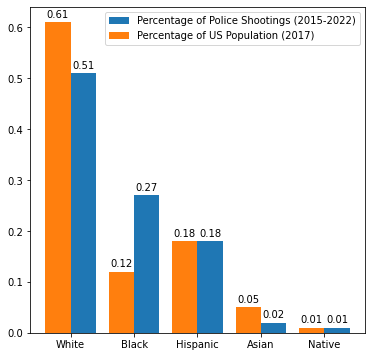

In [17]:
plt.figure(figsize=(8, 3))
labels = ['White', 'Black', 'Hispanic', 'Asian', 'Native',]
x_axis = np.arange(len(labels))


fig, ax = plt.subplots(figsize=(6, 6))
police = ax.bar(x_axis + 0.2, list(np.round(racial_makeup['Percentage of All Police Shootings'][:5] * 1, 2)), 0.4, label = 'Percentage of Police Shootings (2015-2022)')
pop = ax.bar(x_axis - 0.2, list(np.round(race_percent_frame.loc[0].to_numpy().astype(np.double) * 1, 2)), 0.4, label = 'Percentage of US Population (2017)')
ax.set_xticks(x_axis, labels)
ax.bar_label(police, padding=3)
ax.bar_label(pop, padding=3)
ax.legend(prop={'size': 10})


plt.plot()

#### Age

In [18]:
age_makeup = pd.DataFrame({'Age': [], 'Count': [], 'Percentage': []})
age_makeup.Age = shooting_frame.age.value_counts(bins=10).sort_index(axis=0).index.tolist()
age_makeup.Count = shooting_frame.age.value_counts(bins=10).sort_index(axis=0).tolist()
age_makeup.Percentage = shooting_frame.age.value_counts(bins=10, normalize=True).sort_index(axis=0).tolist()
age_makeup


,Age,Count,Percentage
0,"(5.914, 14.5]",7,0.001412
1,"(14.5, 23.0]",678,0.136749
2,"(23.0, 31.5]",1307,0.263614
3,"(31.5, 40.0]",1318,0.265833
4,"(40.0, 48.5]",728,0.146833
5,"(48.5, 57.0]",551,0.111134
6,"(57.0, 65.5]",252,0.050827
7,"(65.5, 74.0]",85,0.017144
8,"(74.0, 82.5]",23,0.004639
9,"(82.5, 91.0]",9,0.001815


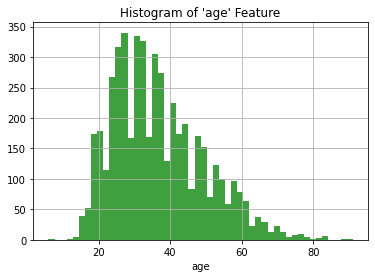

In [19]:
histogram_feature('age', shooting_frame)

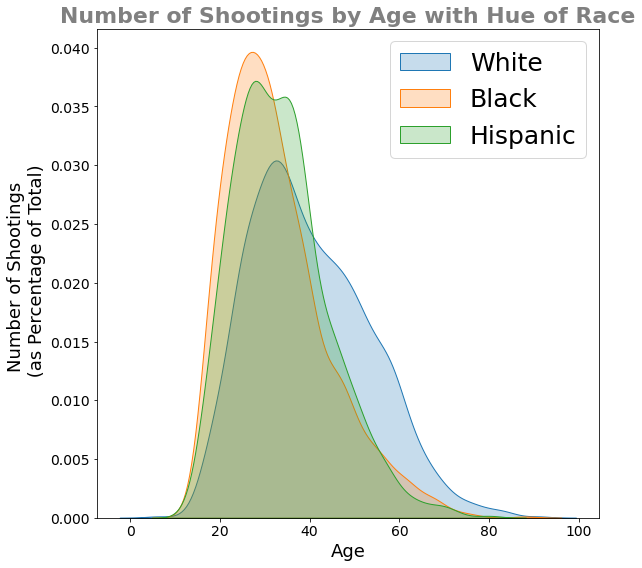

In [20]:
f, ax = plt.subplots(figsize=(9, 9))
sns.kdeplot(shooting_frame.age[shooting_frame.race == 'W'], shade=True, label='White')
sns.kdeplot(shooting_frame.age[shooting_frame.race == 'B'], shade=True, label='Black')
sns.kdeplot(shooting_frame.age[shooting_frame.race == 'H'], shade=True, label='Hispanic')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Number of Shootings \n (as Percentage of Total)', fontsize=18)
plt.title('Number of Shootings by Age with Hue of Race', fontweight='bold', fontsize=22, color='grey')
plt.legend(prop={'size': 25})
plt.show()

#### Gender

In [21]:
gender_makeup = pd.DataFrame({'Gender': [], 'Count': [], 'Percentage': []})
gender_makeup.Gender = shooting_frame.gender.value_counts().index.tolist()
gender_makeup.Count = shooting_frame.gender.value_counts().tolist()
gender_makeup.Percentage = shooting_frame.gender.value_counts(normalize=True).tolist()
gender_makeup

,Gender,Count,Percentage
0,M,4708,0.949576
1,F,250,0.050424


#### Geography

In [22]:
state_makeup = pd.DataFrame({'State': [], 'Count': [], 'Percentage': []})
state_makeup.State = shooting_frame.state.value_counts().index.tolist()
state_makeup.Count = shooting_frame.state.value_counts().tolist()
state_makeup.Percentage = shooting_frame.state.value_counts(normalize=True).tolist()

In [23]:
from collections import Counter

by_state = census_frame[['State', 'TotalPop']]
state_pop_dict = Counter()
for i in by_state.index:
  by_state.loc[i]['State']
  state_pop_dict[by_state.loc[i]['State']] += by_state.loc[i]['TotalPop']

In [24]:
state_pop_frame = pd.DataFrame.from_dict(state_pop_dict, orient='index', columns=['TotalPop']).sort_values('TotalPop', ascending=False)

<BarContainer object of 51 artists>

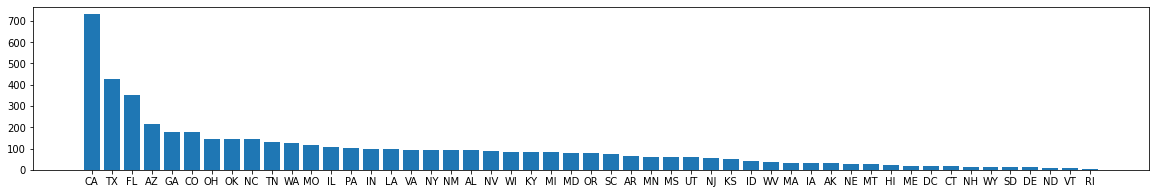

In [25]:
plt.figure(figsize=(20, 3))
plt.bar(state_makeup.State, state_makeup.Count)

<BarContainer object of 52 artists>

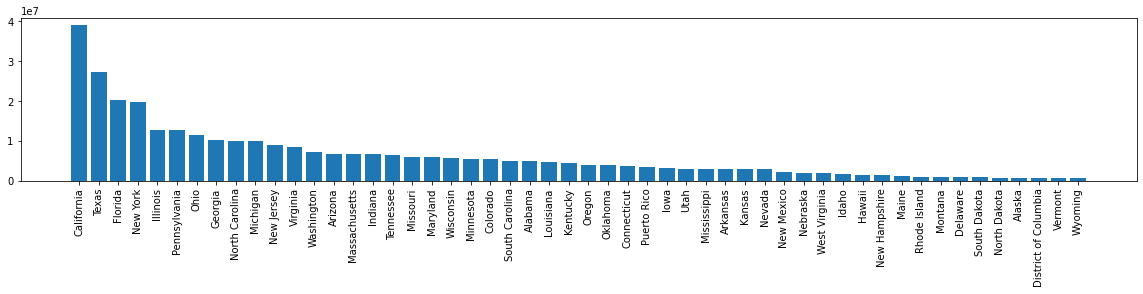

In [26]:
plt.figure(figsize=(20, 3))
plt.xticks(rotation = 90)
plt.bar(state_pop_frame.index, state_pop_frame.TotalPop)

In [27]:
by_state = census_frame[['State', 'TotalPop']]
state_pop_dict = Counter()
for i in by_state.index:
  by_state.loc[i]['State']
  state_pop_dict[by_state.loc[i]['State']] += by_state.loc[i]['TotalPop']

In [28]:
city_makeup = pd.DataFrame({'City': [],'State': [], 'Count': [], 'Percentage': []})
city_makeup.City = shooting_frame.city.value_counts().index.tolist()
city_makeup.Count = shooting_frame.city.value_counts().tolist()
city_makeup.Percentage = shooting_frame.city.value_counts(normalize=True).tolist()
city_makeup.head(10)

,City,State,Count,Percentage
0,Los Angeles,NaN,76,0.015329
1,Phoenix,NaN,67,0.013514
2,Houston,NaN,48,0.009681
3,Las Vegas,NaN,46,0.009278
4,San Antonio,NaN,40,0.008068
5,Jacksonville,NaN,36,0.007261
6,Chicago,NaN,36,0.007261
7,Columbus,NaN,35,0.007059
8,St. Louis,NaN,31,0.006253
9,Albuquerque,NaN,31,0.006253


In [29]:
# city_makeup[['City', 'State', 'Count']].head(10)
top_10 = city_makeup.head(10).copy()
top_10.State = ['CA', 'AZ', 'TX', 'NV', 'TX', 'FL', 'IL', 'OH', 'MO', 'NM']
top_10
top_10[['City', 'State', 'Count']].head(10).to_latex(index=False)

'\\begin{tabular}{llr}\n\\toprule\n        City & State &  Count \\\\\n\\midrule\n Los Angeles &    CA &     76 \\\\\n     Phoenix &    AZ &     67 \\\\\n     Houston &    TX &     48 \\\\\n   Las Vegas &    NV &     46 \\\\\n San Antonio &    TX &     40 \\\\\nJacksonville &    FL &     36 \\\\\n     Chicago &    IL &     36 \\\\\n    Columbus &    OH &     35 \\\\\n   St. Louis &    MO &     31 \\\\\n Albuquerque &    NM &     31 \\\\\n\\bottomrule\n\\end{tabular}\n'

<BarContainer object of 10 artists>

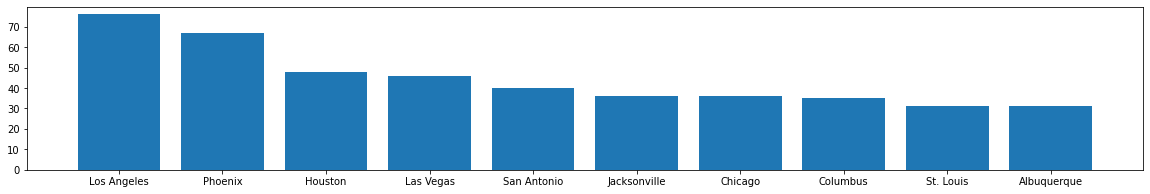

In [30]:
plt.figure(figsize=(20, 3))
plt.bar(city_makeup.City[:10], city_makeup.Count[:10])

Locating Hotspots

The dataset lists the town or city where the shootings occur, but does not account for whether a given town is considered to be a suburb of a larger city (ex. there are shootings reported in College Park, GA, which is a suburb of Atlanta). Clustering by coordinates of the shootings allows us to determine hotspots for police violence. By calculating the center of these clusters, we are able to associate shootings that occurred outside the city limits of a given city with that city. This is beneficial to us in determining which cities are prone to violence, as local news stations often service the cities they are based in and the metropolitan areas that surround them, giving us a larger number of cases to pull from for given local stations.

In [31]:
fig = go.Figure(data=go.Choropleth(
    locations=state_makeup['State'],
    z = state_makeup['Count'],
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Fatal Shootings",
))

# fig.update_layout(
#     title_text = 'Total Fatal Shootings per State (2015-2022)',
#     geo_scope='usa',
# )


In [32]:
contiguous = shooting_frame[(shooting_frame['state'] != 'AK') & (shooting_frame['state'] != 'HI')]
fig = go.Figure(data=go.Scattergeo(
        lon = shooting_frame['longitude'],
        lat = shooting_frame['latitude'],
        mode = 'markers',
        marker_color = 'red',
        opacity = 0.4
        ))

fig.update_layout(
        geo_scope='usa',
    )
fig.show()

In [33]:
lats = contiguous['latitude'].dropna().astype(float).to_numpy().squeeze()
longs = contiguous['longitude'].dropna().astype(float).to_numpy().squeeze()
X = np.vstack((lats, longs)).T

In [34]:
db = DBSCAN(eps=.2, min_samples=25).fit(X)

Text(0, 0.5, 'Latitude')

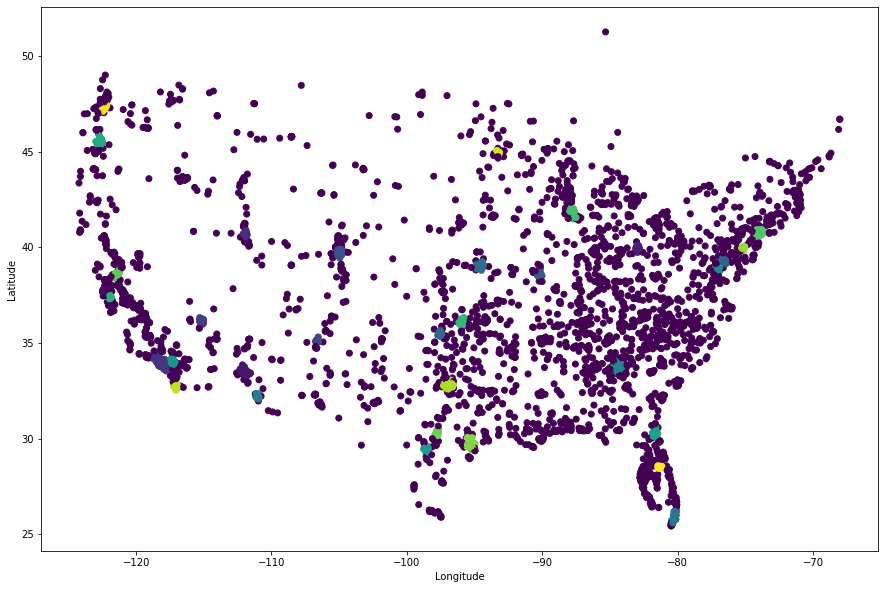

In [35]:
clusters = db.fit_predict(X)
clustered_shooting_frame =  contiguous.copy()
clustered_shooting_frame['cluster'] = clusters
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 1], X[:, 0], c=clusters, cmap="viridis")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


In [36]:
clustered = np.column_stack((clusters[:, np.newaxis], X[:, :]))
cluster_assignment_dict = {}
for i in range(clustered.shape[0]):
  try:
    cluster_assignment_dict[clustered[i, 0]].append((clustered[i, 1], clustered[i, 2]))
  except:
    cluster_assignment_dict[clustered[i, 0]] = [(clustered[i, 1], clustered[i, 2])]

In [37]:
top_x = 10

clusters_ll = sorted([cluster_assignment_dict[key] for key in cluster_assignment_dict.keys()], key=lambda x: len(x), reverse=True)
clusters_ll_full = [cluster_assignment_dict[key] for key in cluster_assignment_dict.keys()]
centroids = [(MultiPoint(cl).centroid, len(cl), i) for i, cl in enumerate(clusters_ll[1:(top_x + 1)])]
centroids_full = [(MultiPoint(cl).centroid, len(cl), i) for i, cl in enumerate(clusters_ll_full[1:])]
centroid_coords = np.array(([point[0].x for point in centroids], [point[0].y for point in centroids])).T
centroid_coords_full = np.array(([point[0].x for point in centroids_full], [point[0].y for point in centroids_full])).T

In [38]:
fig = go.Figure(data=go.Scattergeo(
        lon = centroid_coords[:, 1],
        lat = centroid_coords[:, 0],
        mode = 'markers',
        marker_color = 'Red',
        text = ["Rank {0}, {1} shootings".format(centroid[2] + 1, centroid[1]) for centroid in centroids],
        marker = dict(
            size = 9,
            symbol = '0',
            line = dict(
                width=1,
                color='rgba(255, 0, 0)'
            ),
            colorscale = 'Reds',
            cmin = min([centroid[1] for centroid in centroids]),
            color = [centroid[1] for centroid in centroids],
            cmax = min([centroid[1] for centroid in centroids])
      )))

fig.update_layout(
        title = 'Cities with Highest Concentration of Police Shootings',
        geo_scope = 'usa'
    )
fig.show()

Assingning cluster centers to nearest city.

In [39]:
# https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

In [40]:
cilats = cities_frame['lat'].dropna().astype(float).to_numpy().squeeze()
cilongs = cities_frame['lng'].dropna().astype(float).to_numpy().squeeze()
ci_coords = np.vstack((cilats, cilongs)).T

cilats_full = cities_frame['lat'].dropna().astype(float).to_numpy().squeeze()
cilongs_full = cities_frame['lng'].dropna().astype(float).to_numpy().squeeze()
ci_coords_full = np.vstack((cilats_full, cilongs_full)).T

In [41]:
city_assignment = []
for i in range(centroid_coords.shape[0]):
  curr_city = cities_frame.loc[closest_node(centroid_coords[i, :], ci_coords)].city
  curr_state = cities_frame.loc[closest_node(centroid_coords[i, :], ci_coords)].admin_name
  city_assignment.append((curr_city, curr_state))
  #print(closest_node(centroid_coords[i, :], ci_coords))

In [42]:
city_assignment_full = []
for i in range(centroid_coords_full.shape[0]):
  curr_city = cities_frame.loc[closest_node(centroid_coords_full[i, :], ci_coords_full)].city
  curr_state = cities_frame.loc[closest_node(centroid_coords_full[i, :], ci_coords_full)].admin_name
  city_assignment_full.append((curr_city, curr_state))
  #print(closest_node(centroid_coords[i, :], ci_coords))

In [43]:
clustered_cities_frame = pd.DataFrame([np.array([x[0] for x in city_assignment]),
                                       np.array([x[1] for x in city_assignment]),
                                       np.array([centroid[1] for centroid in centroids])
                                      ]).T.rename(columns={0: 'city', 1: 'state', 2: 'shootings'})
clustered_cities_frame

,city,state,shootings
0,Long Beach,California,239
1,Phoenix,Arizona,133
2,Denver,Colorado,93
3,Arlington,Texas,66
4,Houston,Texas,66
5,Manhattan,New York,64
6,Atlanta,Georgia,63
7,North Las Vegas,Nevada,56
8,Miami,Florida,55
9,Chicago,Illinois,55


In [44]:
# clustered_cities_frame.rename({'city': 'City', 'state': 'State', 'shootings': 'Count'}).to_latex(index=False)

In [45]:
# city_assignment_full_dict = {}
# city_assignment_full_dict[-1] = 'N/A'
# for i, v in enumerate(city_assignment_full):
#   city_assignment_full_dict[i] = v
# print(city_assignment_full_dict)

In [46]:
# Because I can't get the order right and don't want to bother
by_hand_clusters = {-1: 'N/A'}
for i in range(33):
  by_hand_clusters[i] = clustered_shooting_frame[clustered_shooting_frame.cluster == i].city.mode().loc[0]

In [47]:
by_hand_clusters

{-1: 'N/A',
 0: 'San Francisco',
 1: 'Phoenix',
 2: 'Columbus',
 3: 'Salt Lake City',
 4: 'Los Angeles',
 5: 'Las Vegas',
 6: 'Albuquerque',
 7: 'Denver',
 8: 'St. Louis',
 9: 'Baltimore',
 10: 'Oklahoma City',
 11: 'Kansas City',
 12: 'Miami',
 13: 'Tucson',
 14: 'Atlanta',
 15: 'Washington',
 16: 'San Bernardino',
 17: 'San Antonio',
 18: 'Jacksonville',
 19: 'Portland',
 20: 'San Jose',
 21: 'Tulsa',
 22: 'Chicago',
 23: 'New York',
 24: 'Sacramento',
 25: 'Austin',
 26: 'Houston',
 27: 'Philadelphia',
 28: 'Dallas',
 29: 'San Diego',
 30: 'Minneapolis',
 31: 'Tacoma',
 32: 'Orlando'}

In [48]:
# clustered_shooting_frame[clustered_shooting_frame.city == 'Oakland']
# clustered_shooting_frame[clustered_shooting_frame.cluster == 1]

In [49]:
# Assign cluster numbers to cities
clustered_shooting_frame['cluster'] = clustered_shooting_frame['cluster'].map(by_hand_clusters)

In [50]:
clustered_shooting_frame[clustered_shooting_frame['cluster'] == ('Atlanta')]
# clustered_shooting_frame

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,cluster
132,174,Michael Wayne Smashey,2015-02-23,shot,knife,37.0,M,W,Powder Springs,GA,False,other,Not fleeing,False,-84.695,33.911,True,Atlanta
171,205,Anthony Hill,2015-03-09,shot,unarmed,27.0,M,B,Atlanta,GA,True,other,Not fleeing,False,-84.267,33.880,True,Atlanta
225,239,Nicholas Thomas,2015-03-25,shot,undetermined,23.0,M,B,Smyrna,GA,False,other,Car,True,-84.477,33.866,True,Atlanta
324,421,Alexia Christian,2015-04-29,shot,gun,25.0,F,B,Atlanta,GA,False,attack,Not fleeing,False,-84.390,33.752,True,Atlanta
513,629,Frederick Farmer,2015-07-13,shot,gun,20.0,M,B,Stone Mountain,GA,False,attack,Not fleeing,False,-84.212,33.823,True,Atlanta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6248,6834,Matthew Zadok Williams,2021-04-12,shot,knife,35.0,M,B,Decatur,GA,True,other,Not fleeing,True,-84.190,33.712,True,Atlanta
6343,6860,Tyrone Penny,2021-05-18,shot and Tasered,undetermined,21.0,M,B,Decatur,GA,False,undetermined,Other,False,-84.297,33.770,True,Atlanta
6409,6919,Terrell J. Gas,2021-06-09,shot,gun,36.0,M,B,Atlanta,GA,False,attack,Other,False,-84.473,33.616,True,Atlanta
6488,6976,Joseph Lee Humbles,2021-06-30,shot,gun,29.0,M,B,Atlanta,GA,False,attack,Not fleeing,False,-84.385,33.774,True,Atlanta


In [51]:
cities_list = by_hand_clusters.values()
victims = []
for city in cities_list:
  victims.append(clustered_shooting_frame[clustered_shooting_frame['cluster'] == (city)].sample(n=3))

In [52]:
pd.concat(victims)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,cluster
3985,4401,Danny Kelley,2019-01-16,shot,knife,32.0,M,W,Charlotte,NC,False,other,Foot,False,-80.915,35.181,True,N/A
4939,5338,Drew Nichols Wallas-Flores,2020-01-05,shot,gun,30.0,M,H,Lubbock,TX,False,attack,Foot,False,-101.902,33.509,True,N/A
3829,4193,Keaton James Larson,2018-11-21,shot,knife,22.0,M,W,Stillwater,MN,True,other,Not fleeing,True,-92.808,45.045,True,N/A
5231,5671,Steven Taylor,2020-04-18,shot,baseball bat,33.0,M,B,San Leandro,CA,True,other,Not fleeing,False,-122.130,37.689,True,San Francisco
2293,2556,Nicholas Flusche,2017-05-03,shot,knife,26.0,M,W,San Francisco,CA,False,attack,Not fleeing,True,-122.408,37.784,True,San Francisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,1778,Jeff Martelli,2016-08-11,shot,gun,59.0,M,W,Tukwila,WA,True,attack,Not fleeing,False,-122.261,47.466,True,Tacoma
2960,3290,Michael Bender,2018-01-07,shot,gun,27.0,M,W,Tacoma,WA,False,attack,Not fleeing,False,-122.436,47.204,True,Tacoma
5058,5531,Kevin Adolphe,2020-02-18,shot,gun,23.0,M,B,Orlando,FL,False,other,Foot,False,-81.459,28.496,True,Orlando
531,651,Albert Joseph Davis,2015-07-17,shot and Tasered,unarmed,23.0,M,B,Orlando,FL,False,attack,Foot,False,-81.334,28.522,True,Orlando


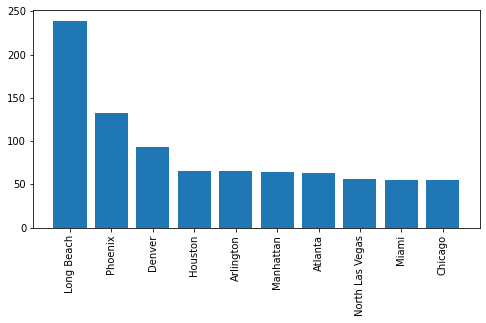

In [53]:
clustered_cities_frame_full = pd.DataFrame([np.array([x[0] for x in city_assignment_full]),
                                            np.array([x[1] for x in city_assignment_full]),
                                            np.array([centroid[1] for centroid in centroids_full])
                                           ]).T.rename(columns={0: 'city', 1: 'state', 2: 'shootings'})
plt.figure(figsize=(8, 4))
ordered = clustered_cities_frame_full.sort_values('shootings', ascending=False)
plt.bar(ordered['city'][:10], ordered['shootings'][:10])
plt.xticks(rotation='vertical')
plt.show()

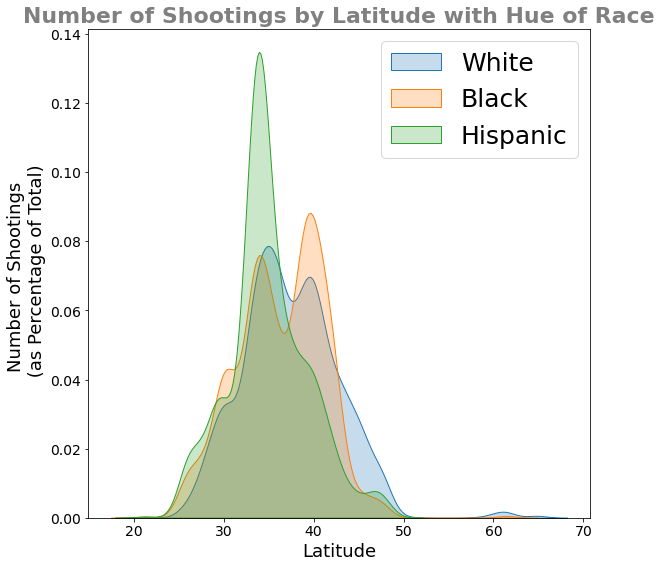

In [54]:
f, ax = plt.subplots(figsize=(9, 9))
sns.kdeplot(shooting_frame.latitude[shooting_frame.race == 'W'], shade=True, label='White')
sns.kdeplot(shooting_frame.latitude[shooting_frame.race == 'B'], shade=True, label='Black')
sns.kdeplot(shooting_frame.latitude[shooting_frame.race == 'H'], shade=True, label='Hispanic')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Number of Shootings \n (as Percentage of Total)', fontsize=18)
plt.title('Number of Shootings by Latitude with Hue of Race', fontweight='bold', fontsize=22, color='grey')
plt.legend(prop={'size': 25})
plt.show()

#### Threat Factors

In [55]:
unarmed_makeup = shooting_frame.loc[shooting_frame['armed'] == 'unarmed']
unarmed_makeup.race.value_counts()

W    163
B    124
H     72
A      8
O      5
N      4
Name: race, dtype: int64

#### Time

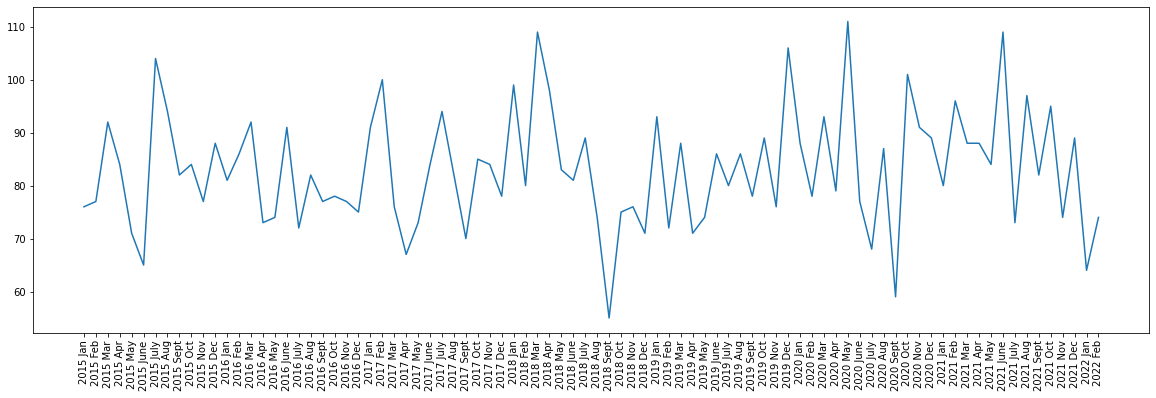

In [56]:
b = shooting_frame_w_na
b['date'] = pd.to_datetime(b['date'])
x = b['date'].groupby([b.date.dt.year, b.date.dt.month]).agg('count')
plt.figure(figsize=(20, 6))
y = list(x)
plt.plot(range(len(x.index)), y)
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
label_list = []
for y in years:
  label_list.extend(['{0} {1}'.format(y, m) for m in months])

plt.xticks(ticks = range(len(x)), labels = label_list[:len(x)], rotation='vertical')
plt.show()

In [57]:
# plt.plot(range(len(x.index)), y)


# plt.xticks(ticks = range(len(years)), labels = years, rotation='vertical')
# plt.show()

## Demographics Analsyis

#### Race

In [58]:
from scipy.stats import mannwhitneyu
import math

In [59]:
ph = census_frame[census_frame['County'] == 'Maricopa County']
la = census_frame[census_frame['County'] == 'Los Angeles County']
phla_frame_analysis = pd.read_csv("/content/framing-differences - LA vs Phoenix.csv")

In [60]:
counties = ph.append(la)
counties

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
597,4013,Arizona,Maricopa County,4155501,2055464,2100037,30.6,56.3,5.1,1.5,...,1.5,2.5,6.4,25.8,1929015,82.8,11.1,5.9,0.1,6.0
465,6037,California,Los Angeles County,10105722,4979641,5126081,48.4,26.5,7.9,0.2,...,2.7,2.3,5.3,30.9,4805817,79.3,11.2,9.3,0.2,7.8


In [61]:
phla_frame_analysis

,Victim Frame,Los Angeles,Phoenix,Cohen's D
0,Official report ***,0.657,0.893,0.572
1,Attack ***,0.290,0.523,0.491
2,Age ***,0.592,0.804,0.466
3,Armed ***,0.392,0.579,0.381
4,Legal language **,0.803,0.856,0.140
5,Video **,0.063,0.098,0.133
6,Fleeing *,0.246,0.302,0.126
7,Gender *,0.636,0.692,0.118
8,Unarmed,0.037,0.040,0.015
9,Mental illness,0.084,0.072,-0.046


In [62]:
phla_frame_analysis.to_latex(index=False)

"\\begin{tabular}{lrrr}\n\\toprule\n       Victim Frame &  Los Angeles &  Phoenix &  Cohen's D \\\\\n\\midrule\nOfficial report *** &        0.657 &    0.893 &      0.572 \\\\\n         Attack *** &        0.290 &    0.523 &      0.491 \\\\\n            Age *** &        0.592 &    0.804 &      0.466 \\\\\n          Armed *** &        0.392 &    0.579 &      0.381 \\\\\n  Legal language ** &        0.803 &    0.856 &      0.140 \\\\\n           Video ** &        0.063 &    0.098 &      0.133 \\\\\n          Fleeing * &        0.246 &    0.302 &      0.126 \\\\\n           Gender * &        0.636 &    0.692 &      0.118 \\\\\n            Unarmed &        0.037 &    0.040 &      0.015 \\\\\n     Mental illness &        0.084 &    0.072 &     -0.046 \\\\\n          Interview &        0.606 &    0.576 &     -0.060 \\\\\n       Systemic *** &        0.173 &    0.111 &     -0.174 \\\\\nCriminal record *** &        0.611 &    0.497 &     -0.232 \\\\\n           Race *** &        0.252 &    0.0

In [63]:
races = counties[["County", "Hispanic", "White", "Black"]]
races

,County,Hispanic,White,Black
597,Maricopa County,30.6,56.3,5.1
465,Los Angeles County,48.4,26.5,7.9


In [64]:
demo_results = races.append({'County': 'Difference:', 'Hispanic': -17.8, 'White': 29.8, 'Black': -2.8}, ignore_index=True)
demo_results.T.to_latex()


'\\begin{tabular}{llll}\n\\toprule\n{} &                0 &                   1 &            2 \\\\\n\\midrule\nCounty   &  Maricopa County &  Los Angeles County &  Difference: \\\\\nHispanic &             30.6 &                48.4 &        -17.8 \\\\\nWhite    &             56.3 &                26.5 &         29.8 \\\\\nBlack    &              5.1 &                 7.9 &         -2.8 \\\\\n\\bottomrule\n\\end{tabular}\n'

Positive results mean a higher ratio in Phoneix, while negative results mean higher ratio in Los Angeles. 

In [65]:
la_shootings = clustered_shooting_frame[clustered_shooting_frame["cluster"] == "Los Angeles"]
la_counts = la_shootings['race'].value_counts()

In [66]:
ph_shootings = clustered_shooting_frame[clustered_shooting_frame["cluster"] == "Phoenix"]
ph_counts = ph_shootings['race'].value_counts()

In [67]:
la_ratio = la_counts / round(sum(la_counts), 3)
ph_ratio = ph_counts / round(sum(ph_counts), 3)

In [68]:
shooting_ratios = pd.DataFrame({'Phoenix': ph_ratio, 'Los Angeles': la_ratio, 'Difference': ph_ratio.subtract(la_ratio)})
shooting_ratios.drop(['A', 'N', 'O']).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &   Phoenix &  Los Angeles &  Difference \\\\\n\\midrule\nB &  0.127820 &     0.225941 &   -0.098122 \\\\\nH &  0.398496 &     0.552301 &   -0.153805 \\\\\nW &  0.436090 &     0.163180 &    0.272910 \\\\\n\\bottomrule\n\\end{tabular}\n'

Positive results mean a higher ratio in Phoneix, while negative results mean higher ratio in Los Angeles. 

#### Age

In [69]:
la_shootings = clustered_shooting_frame[clustered_shooting_frame["cluster"] == "Los Angeles"]
la_counts = la_shootings['age'].value_counts(bins=[12, 18, 25, 35, 45, 55, 65, 75])

In [70]:
ph_shootings = clustered_shooting_frame[clustered_shooting_frame["cluster"] == "Phoenix"]
ph_counts = ph_shootings['age'].value_counts(bins=[12, 18, 25, 35, 45, 55, 65, 75])

In [71]:
la_ratio = la_counts / round(sum(la_counts), 3)
ph_ratio = ph_counts / round(sum(ph_counts), 3)

In [72]:
shooting_ratios = pd.DataFrame({'Phoenix': ph_ratio, 'Los Angeles': la_ratio, 'Difference': ph_ratio.subtract(la_ratio)})
shooting_ratios.multiply(100).round(1).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Phoenix &  Los Angeles &  Difference \\\\\n\\midrule\n(11.999, 18.0] &      3.8 &          6.3 &        -2.5 \\\\\n(18.0, 25.0]   &     20.6 &         16.3 &         4.3 \\\\\n(25.0, 35.0]   &     35.1 &         40.2 &        -5.1 \\\\\n(35.0, 45.0]   &     22.9 &         23.4 &        -0.5 \\\\\n(45.0, 55.0]   &     10.7 &         10.9 &        -0.2 \\\\\n(55.0, 65.0]   &      3.1 &          2.5 &         0.5 \\\\\n(65.0, 75.0]   &      3.8 &          0.4 &         3.4 \\\\\n\\bottomrule\n\\end{tabular}\n'

Positive results mean a higher ratio in Phoneix, while negative results mean higher ratio in Los Angeles. 

## Random Forest

In [73]:
#print(census_frame.head())
#census_frame.iloc[0]
#census_frame = pd.read_csv('./acs2017_county_data.csv')
#census_frame.head()
#census_frame.astype(bool).sum(axis=0)
#(census_frame == 0).sum()
#(census_frame['Pacific'] == 0).sum()
#print(shooting_frame.head())
shooting_frame_noid = shooting_frame.loc[:, shooting_frame.columns != 'id']
shooting_frame_shot = shooting_frame_noid[shooting_frame_noid['manner_of_death'] == 'shot']
shooting_frame_shot = shooting_frame_shot.drop(['name', 'manner_of_death', 'is_geocoding_exact', 'date'], axis = 1) 
y = pd.get_dummies(shooting_frame_shot['armed'], prefix='Weapon')
y
#one_hot = OneHotEncoder()
#data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
#shooting_frame_shot.iloc[:,1]
#corr = shooting_frame_shot.corr()
#sns.heatmap(corr)

,Weapon_Airsoft pistol,Weapon_BB gun,Weapon_BB gun and vehicle,Weapon_Taser,Weapon_air conditioner,Weapon_air pistol,Weapon_ax,Weapon_barstool,Weapon_baseball bat,Weapon_baseball bat and bottle,...,Weapon_tire iron,Weapon_toy weapon,Weapon_unarmed,Weapon_undetermined,Weapon_unknown weapon,Weapon_vehicle,Weapon_vehicle and gun,Weapon_vehicle and machete,Weapon_wasp spray,Weapon_wrench
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
from sklearn.preprocessing import OneHotEncoder
shooting_frame_shot.dropna(inplace=True)
races = shooting_frame_shot['race'].unique()
races = ['Asian', 'White', 'Hispanic', 'Black', 'Native American', 'Other']
races_df = pd.DataFrame(races, columns=['Race'])
dum_df = pd.get_dummies(races_df, columns=["Race"], prefix=["Race"])
shooting_frame_noid = shooting_frame_noid.join(dum_df)
shooting_frame_noid
#enc = OneHotEncoder(handle_unknown='ignore')
#onehot = shooting_frame_shot['race']
#np.reshape(onehot, (-1,1))
#np.shape(onehot)
#enc_df = pd.DataFrame(np.reshape(, [-1,1]))
#enc_df
#shooting_frame_race = shooting_frame.loc[:, shooting_frame.columns == 'race']
#shooting_frame_race.dropna(inplace = True) 
#shooting_frame_race['race'] = shooting_frame_race['race'].dropna() 
#print(shooting_frame_race['race'].isna().sum())
#print(shooting_frame_race)
#print(shooting_frame_race.head())
#shooting_frame_race = [np.where(shooting_frame_race['race'] == 'B', shooting_frame_race['race'], 0)]
#shooting_frame_race = [np.where(shooting_frame_race['race'] != 'B', shooting_frame_race['race'], 0)]
#shooting_frame_race['race'] = pd.DataFrame(shooting_frame_race['race'].values[:] == 'B')
#shooting_frame_race['race'].isna().sum()
#shooting_frame_race['race'].dropna()
#shooting_frame_race.loc[:, (shooting_frame_race['race'] == 'B')] = 1
#shooting_frame_race.loc[:, (shooting_frame_race['race'] != 'B')] = 0
#shooting_frame_race.head()
#np.isnan(shooting_frame_race)
#shooting_frame_race[~np.isnan(shooting_frame_race).any(axis=1)]


,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,...,body_camera,longitude,latitude,is_geocoding_exact,Race_Asian,Race_Black,Race_Hispanic,Race_Native American,Race_Other,Race_White
0,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,...,False,-123.122,47.247,True,1.0,0.0,0.0,0.0,0.0,0.0
1,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,...,False,-122.892,45.487,True,0.0,0.0,0.0,0.0,0.0,1.0
2,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,...,False,-97.281,37.695,True,0.0,0.0,1.0,0.0,0.0,0.0
3,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,...,False,-122.422,37.763,True,0.0,1.0,0.0,0.0,0.0,0.0
4,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,...,False,-104.692,40.384,True,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,Brian Michael Price,2021-11-06,shot,piece of wood,45.0,M,W,Chesapeake,VA,False,...,False,-78.691,36.653,True,NaN,NaN,NaN,NaN,NaN,NaN
6854,Chelsae L. Clevenger-Kirk,2021-11-07,shot,gun,29.0,F,W,Goodview,VA,True,...,False,-79.699,37.174,True,NaN,NaN,NaN,NaN,NaN,NaN
6969,Shawn Martin,2021-12-21,shot,knife,45.0,M,W,Savannah,GA,False,...,False,-81.140,32.043,True,NaN,NaN,NaN,NaN,NaN,NaN
6975,Brian Douglas Laxton,2021-12-22,shot,gun,44.0,M,W,Battle Creek,MI,False,...,True,-85.175,42.309,True,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
shooting_frame_processed = shooting_frame.drop(['id', 'city', 'state', 'name', 'manner_of_death', 'is_geocoding_exact', 'date'], axis = 1) 
#shooting_frame_processed = shooting_frame.drop(['id', 'city', 'state', 'manner_of_death', 'is_geocoding_exact'], axis = 1) 
shooting_frame_processed.dropna(inplace=True)

race_pd = pd.get_dummies(shooting_frame_processed.race, prefix='race')
shooting_frame_processed = shooting_frame_processed.join(race_pd)

threat_pd = pd.get_dummies(shooting_frame_processed.threat_level, prefix='threat')
shooting_frame_processed = shooting_frame_processed.join(threat_pd)

flee_pd = pd.get_dummies(shooting_frame_processed.flee, prefix='flee')
shooting_frame_processed = shooting_frame_processed.join(flee_pd)

shooting_frame_processed.drop(['race'], axis=1, inplace=True)
shooting_frame_processed.drop(['threat_level'], axis=1, inplace=True)
shooting_frame_processed.drop(['flee'], axis=1, inplace=True)

def clean_armed_status(input): 
  return 0 if input == 'unarmed' else 1
def clean_mental_illness(input): 
  return 1 if input == True else 0
def clean_gender(input): 
  return 1 if input == 'M' else 0
def clean_camera(input): 
  return 1 if input == True else 0

shooting_frame_processed['armed'] = shooting_frame_processed['armed'].apply(clean_armed_status)
shooting_frame_processed['signs_of_mental_illness'] = shooting_frame_processed['signs_of_mental_illness'].apply(clean_mental_illness)
shooting_frame_processed['gender'] = shooting_frame_processed['gender'].apply(clean_gender)
shooting_frame_processed['body_camera'] = shooting_frame_processed['body_camera'].apply(clean_camera)

shooting_frame_processed

,armed,age,gender,signs_of_mental_illness,body_camera,longitude,latitude,race_A,race_B,race_H,race_N,race_O,race_W,threat_attack,threat_other,threat_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,1,53.0,1,1,0,-123.122,47.247,1,0,0,0,0,0,1,0,0,0,0,1,0
1,1,47.0,1,0,0,-122.892,45.487,0,0,0,0,0,1,1,0,0,0,0,1,0
2,0,23.0,1,0,0,-97.281,37.695,0,0,1,0,0,0,0,1,0,0,0,1,0
3,1,32.0,1,1,0,-122.422,37.763,0,0,0,0,0,1,1,0,0,0,0,1,0
4,1,39.0,1,0,0,-104.692,40.384,0,0,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,1,45.0,1,0,0,-78.691,36.653,0,0,0,0,0,1,1,0,0,0,0,0,1
6854,1,29.0,0,1,0,-79.699,37.174,0,0,0,0,0,1,0,1,0,0,0,0,1
6969,1,45.0,1,0,0,-81.140,32.043,0,0,0,0,0,1,1,0,0,0,0,1,0
6975,1,44.0,1,0,1,-85.175,42.309,0,0,0,0,0,1,1,0,0,1,0,0,0


0.6727272727272727
0.6795252225519287


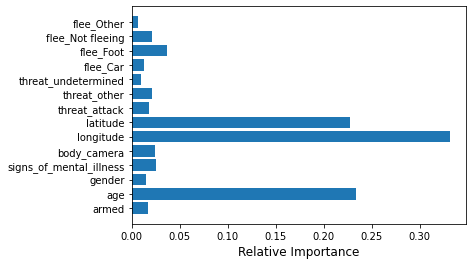

In [76]:
from sklearn.ensemble import RandomForestClassifier
sample_df = shooting_frame_processed.groupby("race_B").sample(n=1000, random_state=1)
rf = RandomForestClassifier(n_estimators = 150, max_depth = 7, criterion="entropy", min_samples_split=4,min_samples_leaf=2, bootstrap=True)
df = sample_df.drop(["race_A", "race_W", "race_H", "race_N", "race_O"], axis=1)
x = df.drop(columns="race_B")
y = df['race_B']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                 test_size = 0.33,
                                                 random_state = 42)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))
pred = rf.predict(X_test)

from sklearn import metrics

score = metrics.f1_score(Y_test, pred)
print(score)
plt.barh(list(x), rf.feature_importances_)
#plt.title('Feature Importance for Black Victims of Police Shootings', fontweight='bold', fontsize=14, color='grey')
plt.xlabel('Relative Importance', fontsize=12)
plt.show()
#rf.score(X_test, Y_test) 

#y_pred_test = rf.predict(X_test)
#from sklearn import tree
#from sklearn.tree import export_graphviz
#fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 800)
#tree.plot_tree(rf.estimators_[0], rounded=True, filled=True, fontsize=14)

0.6757575757575758
0.6707692307692307


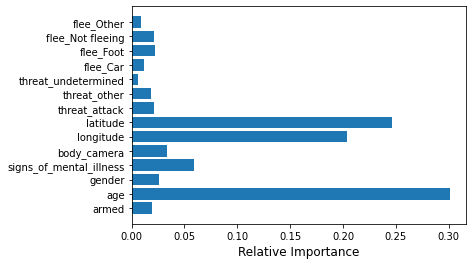

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 150, max_depth = 7, bootstrap=True, criterion="entropy", min_samples_split=4,min_samples_leaf=2)
sample_df = shooting_frame_processed.groupby("race_W").sample(n=1000, random_state=1)
df = sample_df.drop(["race_A", "race_B", "race_H", "race_N", "race_O"], axis=1)
x = df.drop(columns="race_W")
y = df['race_W']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                 test_size = 0.33,
                                                 random_state = 42)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))
pred = rf.predict(X_test)

from sklearn import metrics

score = metrics.f1_score(Y_test, pred)
print(score)
plt.barh(list(x), rf.feature_importances_)
#plt.title('Feature Importance for White Victims of Police Shootings', fontweight='bold', fontsize=14, color='grey')
plt.xlabel('Relative Importance', fontsize=12)
plt.show()

0.8338423946243128


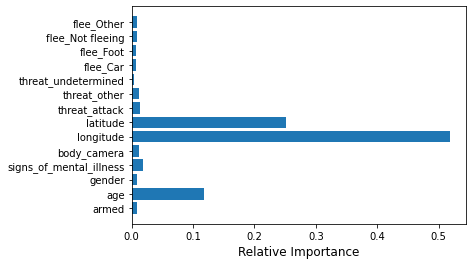

In [78]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 150, max_depth = 7, criterion="entropy", min_samples_split=4,min_samples_leaf=2, bootstrap=True)
sample_df = shooting_frame_processed.groupby("race_H").sample(n=900, random_state=1)
df = shooting_frame_processed.drop(["race_A", "race_B", "race_W", "race_N", "race_O"], axis=1)
x = df.drop(columns="race_H")
y = df['race_H']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                 test_size = 0.33,
                                                 random_state = 42)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))
pred = rf.predict(X_test)

from sklearn import metrics

#score = metrics.f1_score(Y_test, pred)
#print(score)
plt.barh(list(x), rf.feature_importances_)
#plt.title('Feature Importance for Hispanic Victims of Police Shootings', fontweight='bold', fontsize=14, color='grey')
plt.xlabel('Relative Importance', fontsize=12)
plt.show()

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_depth = 3)
sample_df = shooting_frame_processed.groupby("race_N").sample(n=50, random_state=1)
df = shooting_frame_processed.drop(["race_A", "race_B", "race_W", "race_H", "race_O"], axis=1)
x = df.drop(columns="race_N")
y = df['race_N']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                 test_size = 0.33,
                                                 random_state = 42)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

0.9920586438607208

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_depth = 3)
df = shooting_frame_processed.drop(["race_H", "race_B", "race_W", "race_N", "race_O"], axis=1)
x = df.drop(columns="race_A")
y = df['race_A']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                 test_size = 0.33,
                                                 random_state = 42)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

0.9798411728772144

## Feature Importance (Chi-Squared)


In [81]:
# Taken from: https://github.com/apaljug/apaljug.CS7641-Group2.io/blob/main/Song%20Data%20Exploration.ipynb

# Function for plotting a histogram of a feature

def histogram_feature(feature, df, color="g"):
    """
    Takes in a feature and dataframe, plots histogram of feature's values
    
    Parameters:
    - feature (str): feature name for histogram
    - df (pd.DataFrame)
    """
    
    n, bins, patches = plt.hist(df[feature], 50, facecolor=color, alpha=0.75)
    plt.xlabel(f'{feature}')
    plt.title(f"Histogram of '{feature}' Feature")
    plt.grid(True)
    plt.show()

# Function for plotting a scatter plot of two features, one on the x-axis another on the y-axis

def scatterplot_two_features(f1, f2, df):
    """
    Plots scatterplot of two features
    
    Parameters:
    - f1 (str): feature name for x-axis
    - f2 (str): feature name for y-axis
    - df (pd.DataFrame): dataframe
    """
    
    plt.scatter(df[f1], df[f2])
    plt.title(f"Scatterplot of '{f2}' vs. '{f1}'")
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

def clean_armed_status(input):
  if input == 'unarmed':
    return 'unarmed'
  else:
    return 'armed'

def clean_race_label(input):
  if input == 'A':
    return 'Asian'
  elif input == 'B':
    return 'Black'
  elif input == 'W':
    return 'White'
  elif input == 'H':
    return 'Hispanic'
  elif input == 'N':
    return 'Native American'
  elif input == 'O':
    return 'Other'
  else:
    return input

# Chi Square Test of Independence

In [82]:
shooting_frame['armed'] = shooting_frame['armed'].apply(clean_armed_status)
shooting_frame['race'] = shooting_frame['race'].apply(clean_race_label)

shooting_frame.drop('date', axis=1, inplace=True)
shooting_frame.drop('name', axis=1, inplace=True)
shooting_frame.drop('is_geocoding_exact', axis=1, inplace=True)
shooting_frame.drop('city', axis=1, inplace=True)
shooting_frame.drop('state', axis=1, inplace=True)
shooting_frame.drop('id', axis=1, inplace=True)


frame = pd.crosstab(shooting_frame.armed, shooting_frame.race, margins=True)
print(frame)

chi2, p_value, degrees_of_freedom, exp_values = chi2_contingency(frame)


race     Asian  Black  Hispanic  Native American  Other  White   All
armed                                                               
armed       80   1200       839               69     37   2357  4582
unarmed      8    124        72                4      5    163   376
All         88   1324       911               73     42   2520  4958


The following code generates a table of p values for identified factors in the shootings dataset.

In [83]:
def calculate_p_value(factor1, factor2):
  frame = pd.crosstab(shooting_frame[factor1], shooting_frame[factor2], margins=True)
  p_value = chi2_contingency(frame)[1]
  return p_value

resultant = pd.DataFrame(data=[(0 for i in range(len(shooting_frame.columns))) for i in range(len(shooting_frame.columns))], 
                         columns=list(shooting_frame.columns))
resultant.set_index(pd.Index(list(shooting_frame.columns)), inplace = True)

for i in list(shooting_frame.columns):
    for j in list(shooting_frame.columns):
        if i != j:
            p_val = calculate_p_value(i, j)
            resultant.loc[i,j] = p_val

print(tabulate(resultant, headers='keys', tablefmt='psql'))

+-------------------------+-------------------+-------------+-------------+-------------+-------------+---------------------------+----------------+-------------+---------------+-------------+-------------+
|                         |   manner_of_death |       armed |         age |      gender |        race |   signs_of_mental_illness |   threat_level |        flee |   body_camera |   longitude |    latitude |
|-------------------------+-------------------+-------------+-------------+-------------+-------------+---------------------------+----------------+-------------+---------------+-------------+-------------|
| manner_of_death         |       0           | 3.32663e-05 | 1           | 0.783099    | 0.931991    |               0.00307341  |    8.40692e-08 | 0.0317168   |   0.0763519   | 1           | 1           |
| armed                   |       3.32663e-05 | 0           | 0.556582    | 0.967854    | 0.408717    |               0.208498    |    1.21197e-36 | 1.54442e-05 |   0.02221

<AxesSubplot:>

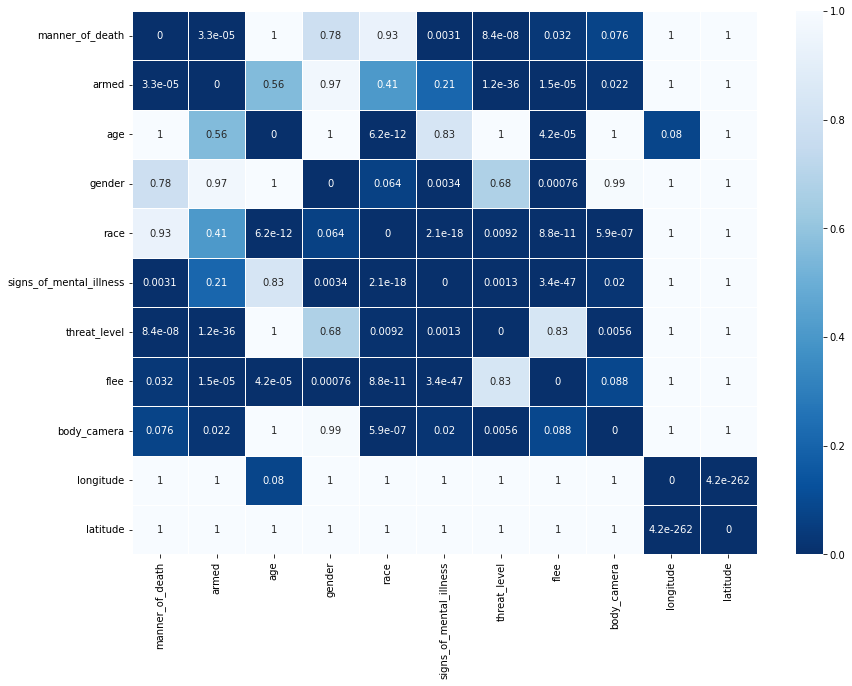

In [84]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(resultant, cmap="Blues_r", vmin=3.7e-68, annot=True, linewidths=0.5, ax=ax)